## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 32.3 s, sys: 230 ms, total: 32.6 s
Wall time: 32.7 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
n_raters = train[TARGETS].nunique().map({9: 12, 17: 20, 5: 5, 3: 3})
ses = (((train[TARGETS]*(1 - train[TARGETS])) / n_raters) **.5).values

In [7]:
# for col in TARGETS:
#     train[col] = train[col].rank(method="average")
# train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [8]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [9]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [10]:
lr = 0.0005
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_5'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [11]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 50, weight_decay)
    )

Fold 1 started at Wed Jan 15 07:46:33 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


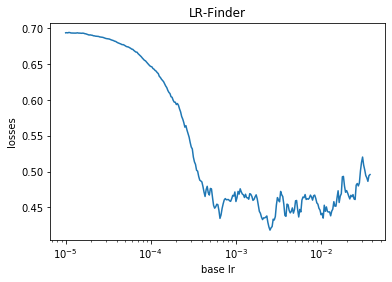

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43463 - spearmanr 0.17045
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.3833 - spearmanr 0.36641


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.36641
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37173 - spearmanr 0.33819
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36594 - spearmanr 0.40115
best model: epoch 1 - 0.40115
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35548 - spearmanr 0.39449
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36206 - spearmanr 0.41053
best model: epoch 2 - 0.41053
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34507 - spearmanr 0.4331
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36029 - spearmanr 0.41532
best model: epoch 3 - 0.41532
TRAINING END: Best score achieved on epoch 3 - 0.41532
Starting inference for model: checkpoints/siamese_bert_5_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_1_best.pth



Fold 2 started at Wed Jan 15 08:26:11 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.4321 - spearmanr 0.17166
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38489 - spearmanr 0.36914
best model: epoch 0 - 0.36914
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37182 - spearmanr 0.33831
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36974 - spearmanr 0.39956
best model: epoch 1 - 0.39956
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35569 - spearmanr 0.39443
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36553 - spearmanr 0.41262
best model: epoch 2 - 0.41262
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34497 - spearmanr 0.4334
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36515 - spearmanr 0.41629
best model: epoch 3 - 0.41629
TRAINING END: Best score achieved on epoch 3 - 0.41629
Starting inference for model: checkpoints/siamese_bert_5_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_2_best.pth



Fold 3 started at Wed Jan 15 09:04:48 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43279 - spearmanr 0.17259
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38323 - spearmanr 0.35202
best model: epoch 0 - 0.35202
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37037 - spearmanr 0.34348
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37394 - spearmanr 0.3901
best model: epoch 1 - 0.3901
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35497 - spearmanr 0.39549
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.37106 - spearmanr 0.39618
best model: epoch 2 - 0.39618
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34506 - spearmanr 0.43182
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.37133 - spearmanr 0.39918
best model: epoch 3 - 0.39918
TRAINING END: Best score achieved on epoch 3 - 0.39918
Starting inference for model: checkpoints/siamese_bert_5_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_3_best.pth



Fold 4 started at Wed Jan 15 09:43:30 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43201 - spearmanr 0.17468
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38015 - spearmanr 0.34227
best model: epoch 0 - 0.34227
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37095 - spearmanr 0.34526
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36627 - spearmanr 0.38348
best model: epoch 1 - 0.38348
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35581 - spearmanr 0.39381
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.3643 - spearmanr 0.39377
best model: epoch 2 - 0.39377
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34431 - spearmanr 0.4342
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36435 - spearmanr 0.39363
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39377
Starting inference for model: checkpoints/siamese_bert_5_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_4_best.pth



Fold 5 started at Wed Jan 15 10:22:09 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43204 - spearmanr 0.17671
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.37498 - spearmanr 0.36068
best model: epoch 0 - 0.36068
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37163 - spearmanr 0.34177
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36211 - spearmanr 0.38925
best model: epoch 1 - 0.38925
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35581 - spearmanr 0.3964
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36108 - spearmanr 0.40015
best model: epoch 2 - 0.40015
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34515 - spearmanr 0.43385
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.35931 - spearmanr 0.4024
best model: epoch 3 - 0.4024
TRAINING END: Best score achieved on epoch 3 - 0.40240
Starting inference for model: checkpoints/siamese_bert_5_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_5_best.pth



Fold 6 started at Wed Jan 15 11:00:51 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43365 - spearmanr 0.17375
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38014 - spearmanr 0.34358
best model: epoch 0 - 0.34358
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37174 - spearmanr 0.34269
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36714 - spearmanr 0.37793
best model: epoch 1 - 0.37793
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35563 - spearmanr 0.39704
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36224 - spearmanr 0.39101
best model: epoch 2 - 0.39101
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34538 - spearmanr 0.43422
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36305 - spearmanr 0.39158
best model: epoch 3 - 0.39158
TRAINING END: Best score achieved on epoch 3 - 0.39158
Starting inference for model: checkpoints/siamese_bert_5_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_6_best.pth



Fold 7 started at Wed Jan 15 11:39:33 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.4327 - spearmanr 0.17668
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38939 - spearmanr 0.35357
best model: epoch 0 - 0.35357
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.3704 - spearmanr 0.34491
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37624 - spearmanr 0.39906
best model: epoch 1 - 0.39906
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35523 - spearmanr 0.39216
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.37031 - spearmanr 0.4042
best model: epoch 2 - 0.4042
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34501 - spearmanr 0.43067
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36927 - spearmanr 0.41323
best model: epoch 3 - 0.41323
TRAINING END: Best score achieved on epoch 3 - 0.41323
Starting inference for model: checkpoints/siamese_bert_5_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_7_best.pth



Fold 8 started at Wed Jan 15 12:18:16 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43354 - spearmanr 0.16906
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38081 - spearmanr 0.36894
best model: epoch 0 - 0.36894
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37044 - spearmanr 0.3391
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37018 - spearmanr 0.39773
best model: epoch 1 - 0.39773
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35528 - spearmanr 0.39491
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36611 - spearmanr 0.4107
best model: epoch 2 - 0.4107
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34472 - spearmanr 0.43108
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36664 - spearmanr 0.41269
best model: epoch 3 - 0.41269
TRAINING END: Best score achieved on epoch 3 - 0.41269
Starting inference for model: checkpoints/siamese_bert_5_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_8_best.pth



Fold 9 started at Wed Jan 15 12:57:00 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43225 - spearmanr 0.17714
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.37988 - spearmanr 0.35217
best model: epoch 0 - 0.35217
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37172 - spearmanr 0.34161
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36796 - spearmanr 0.3825
best model: epoch 1 - 0.3825
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.355 - spearmanr 0.39864
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36521 - spearmanr 0.39388
best model: epoch 2 - 0.39388
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.3442 - spearmanr 0.43503
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36461 - spearmanr 0.3993
best model: epoch 3 - 0.3993
TRAINING END: Best score achieved on epoch 3 - 0.39930
Starting inference for model: checkpoints/siamese_bert_5_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_9_best.pth



Fold 10 started at Wed Jan 15 13:35:42 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43411 - spearmanr 0.17384
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.3787 - spearmanr 0.36427
best model: epoch 0 - 0.36427
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37248 - spearmanr 0.33845
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36265 - spearmanr 0.39912
best model: epoch 1 - 0.39912
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35591 - spearmanr 0.39453
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.35684 - spearmanr 0.41654
best model: epoch 2 - 0.41654
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34601 - spearmanr 0.43161
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.35692 - spearmanr 0.418
best model: epoch 3 - 0.418
TRAINING END: Best score achieved on epoch 3 - 0.41800
Starting inference for model: checkpoints/siamese_bert_5_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_10_best.pth



OOF score: 0.40650771634746646


In [12]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y, 
                    standard_errors=ses), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [13]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

def ahmet_round(preds, ds, indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

In [14]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.1456461912886479
0 10 0.31921463463048494
0 15 0.35635695745931467
0 20 0.3583156820855397
0 33 0.36992919553646525
0 None 0.37361604547762434
1 5 0.6193742788573492
1 10 0.6412818097454834
1 15 0.6452444897429284
1 20 0.646788494461719
1 33 0.646860597292178
1 None 0.6480843176135553
2 5 0.45349115081086994
2 10 0.4839696404032099
2 15 0.4873563339858441
3 5 0.300767140272428
3 10 0.3163397996835689
3 None 0.3163989260986342
4 5 0.32214434899037886
4 10 0.35103807257641984
4 15 0.35613971094179375
4 20 0.3591993477303539
4 33 0.360666268284159
5 5 0.4713271314459892
6 5 0.31355814565235346
6 10 0.31637463029327256
6 15 0.33418539388817026
6 20 0.3390270653805802
6 33 0.34589368369458123
6 None 0.3488649837631538
7 5 0.46406716900927386
7 10 0.4956202023777805
7 33 0.49863456244197896
8 5 0.5697074232709518
8 10 0.5782078596711795
8 15 0.5791403776814751
8 20 0.5797514077075662
9 33 0.02829975374296678
9 None 0.08713174404866303
10 5 0.4587120143270203
10 10 0.4704940888723505
10

In [15]:
opt_ds, opt_indices

([15, 33, 5, 33, 20, 10, 10, 33, 15, 10, 20, 33],
 [2, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 26])

In [16]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.4303068706802039

In [17]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.43433013410434457

In [18]:
spearmanr_np(oofs, y)

0.40650771634746646

In [19]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.41846950129970667

In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.934762,0.656924,0.242477,0.481925,0.628274,0.510285,0.678073,0.657774,0.648280,0.001871,0.728245,0.691496,0.013274,0.174057,0.004490,0.011399,0.091556,0.110828,0.749433,0.000776,0.922527,0.857316,0.512967,0.935059,0.922437,0.749497,0.025368,0.042539,0.798099,0.884402
1,46,0.846585,0.477235,0.003869,0.744900,0.771112,0.912752,0.551168,0.480084,0.026770,0.005239,0.456381,0.133946,0.001852,0.000442,0.000502,0.005469,0.911224,0.208344,0.053383,0.000139,0.624007,0.954022,0.666018,0.977559,0.989437,0.897977,0.950721,0.117052,0.039979,0.900386
2,70,0.912942,0.657702,0.019668,0.715164,0.895934,0.944444,0.603080,0.539695,0.234792,0.001782,0.235643,0.708051,0.014479,0.062703,0.001620,0.004445,0.110414,0.080026,0.676070,0.000594,0.863120,0.914125,0.566432,0.964855,0.964544,0.835999,0.032455,0.042510,0.841056,0.890778
3,132,0.884823,0.427437,0.002233,0.710735,0.778419,0.926648,0.536231,0.428711,0.098376,0.003609,0.546023,0.055034,0.000916,0.001235,0.000205,0.001208,0.865661,0.186587,0.556885,0.000054,0.765429,0.957266,0.701225,0.980194,0.990051,0.906144,0.865860,0.197467,0.662596,0.923817
4,200,0.909865,0.453308,0.026085,0.838187,0.794998,0.890576,0.644431,0.622753,0.172040,0.011852,0.368020,0.443618,0.008239,0.022950,0.008061,0.061001,0.253475,0.118254,0.493314,0.002630,0.682372,0.912982,0.681847,0.967014,0.968402,0.857767,0.294825,0.143086,0.706961,0.903488


In [22]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [23]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.955431,0.746603,0.119908,0.670615,0.621180,0.415217,0.653973,0.608525,0.207263,0.002647,0.796889,0.225710,0.225685,0.033276,0.004557,0.072235,0.147587,0.060995,0.545380,0.000822,0.927356,0.952427,0.693486,0.982348,0.983064,0.900108,0.084142,0.042036,0.895877,0.943306
1,0.976048,0.850934,0.021541,0.660974,0.960611,0.791212,0.623503,0.670557,0.168029,0.001289,0.218992,0.039029,0.759054,0.005212,0.229206,0.021930,0.023032,0.031027,0.275297,0.002581,0.939955,0.905178,0.605821,0.938638,0.958259,0.807424,0.007072,0.017945,0.483992,0.951779
2,0.929943,0.456303,0.003617,0.855359,0.889143,0.905767,0.607673,0.482768,0.185663,0.001077,0.324997,0.291109,0.004420,0.002297,0.000493,0.199576,0.670903,0.106324,0.110621,0.000199,0.812488,0.949692,0.706350,0.980803,0.976962,0.899035,0.557777,0.140025,0.510901,0.937939
3,0.914411,0.735101,0.137467,0.815889,0.808142,0.843984,0.640217,0.666537,0.217857,0.001137,0.315923,0.894994,0.015986,0.023271,0.035722,0.023313,0.027178,0.097503,0.512486,0.002222,0.922483,0.932451,0.749418,0.946535,0.975750,0.899813,0.061159,0.173044,0.883689,0.896486
4,0.933750,0.737264,0.001411,0.773025,0.892032,0.942724,0.569266,0.530456,0.094754,0.000526,0.216748,0.421603,0.000760,0.000486,0.000523,0.002921,0.853047,0.191451,0.114402,0.000054,0.910902,0.926448,0.627960,0.959598,0.971130,0.878854,0.899469,0.088713,0.030540,0.898011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.951098,0.577344,0.053956,0.901900,0.817987,0.815541,0.663816,0.625896,0.289615,0.000842,0.499248,0.851837,0.094929,0.027870,0.007503,0.057893,0.031116,0.028277,0.416113,0.000773,0.883249,0.959742,0.734366,0.986528,0.984787,0.902279,0.064620,0.036286,0.862787,0.957050
6075,0.972658,0.669992,0.039512,0.735828,0.585074,0.386367,0.715607,0.720453,0.012578,0.002861,0.799670,0.007851,0.002577,0.001678,0.000284,0.004734,0.776426,0.244138,0.133406,0.000086,0.913941,0.955846,0.696555,0.981599,0.990231,0.898925,0.787280,0.198667,0.398133,0.959854
6076,0.869820,0.492574,0.001771,0.762136,0.829232,0.934313,0.546226,0.456499,0.133659,0.001801,0.421210,0.281535,0.001744,0.000908,0.000426,0.003191,0.902599,0.248104,0.106534,0.000064,0.746232,0.853075,0.569891,0.935452,0.921106,0.741489,0.619335,0.131416,0.404847,0.787566
6077,0.940866,0.671059,0.576498,0.237285,0.334350,0.136782,0.675316,0.718882,0.725713,0.000882,0.952840,0.494618,0.107772,0.081063,0.009673,0.019116,0.033481,0.167053,0.657955,0.000379,0.949273,0.914577,0.645730,0.963454,0.969833,0.848590,0.018681,0.090655,0.864826,0.954003


In [24]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.373616
question_body_critical                   0.648084
question_conversational                  0.417477
question_expect_short_answer             0.316399
question_fact_seeking                    0.360603
question_has_commonly_accepted_answer    0.430574
question_interestingness_others          0.348865
question_interestingness_self            0.498013
question_multi_intent                    0.578078
question_not_really_a_question           0.087132
question_opinion_seeking                 0.472170
question_type_choice                     0.741307
question_type_compare                    0.353147
question_type_consequence                0.175862
question_type_definition                 0.361585
question_type_entity                     0.444693
question_type_instructions               0.782392
question_type_procedure                  0.358362
question_type_reason_explanation         0.677226
question_type_spelling                   0.063737


In [25]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.063737,3.0
question_not_really_a_question,0.087132,5.0
answer_plausible,0.145025,9.0
answer_relevance,0.173537,9.0
question_type_consequence,0.175862,5.0
answer_well_written,0.187128,9.0
answer_helpful,0.231879,9.0
answer_type_procedure,0.295477,5.0
answer_satisfaction,0.314528,17.0
question_expect_short_answer,0.316399,5.0


In [26]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

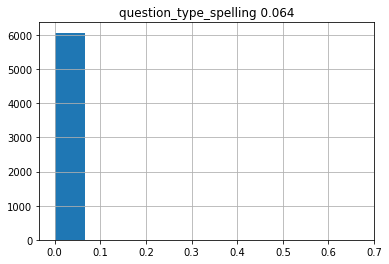

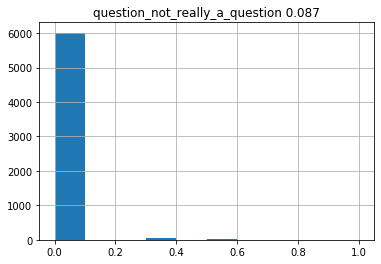

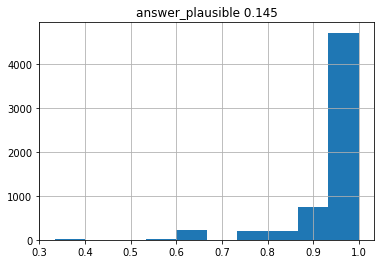

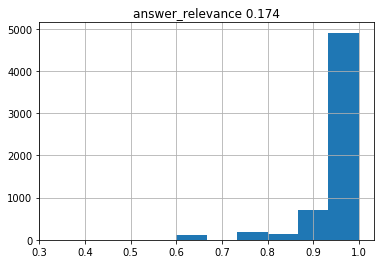

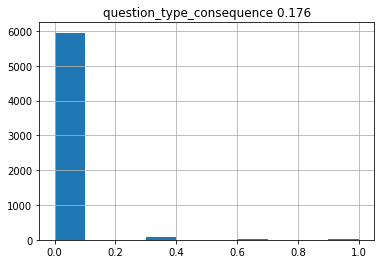

In [27]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


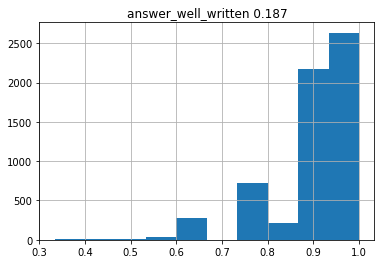

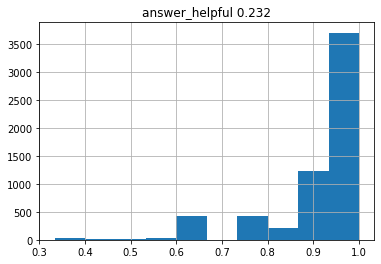

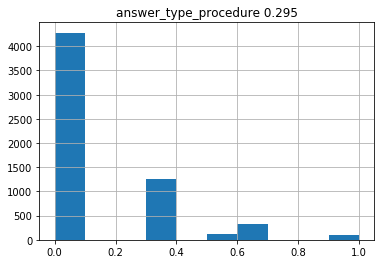

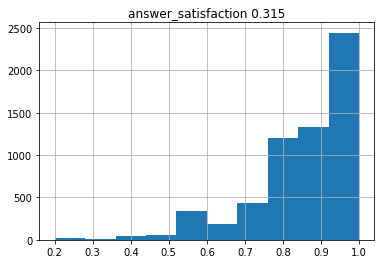

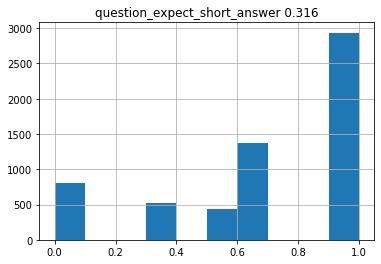

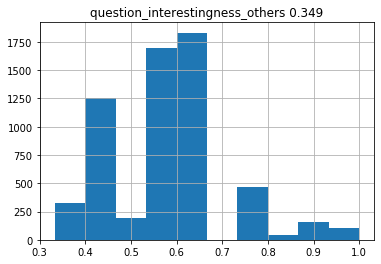

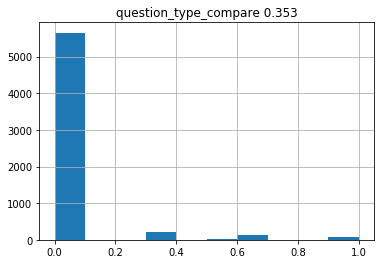

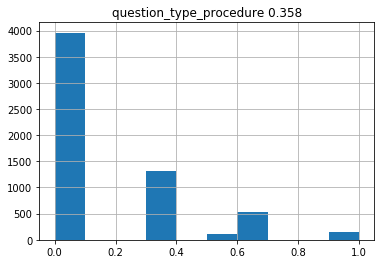

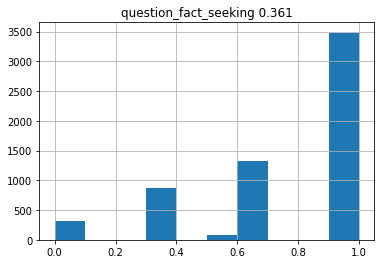

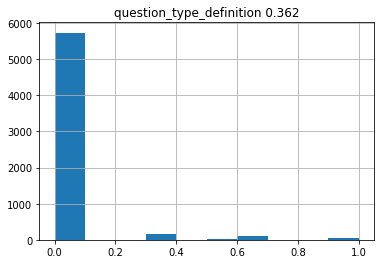

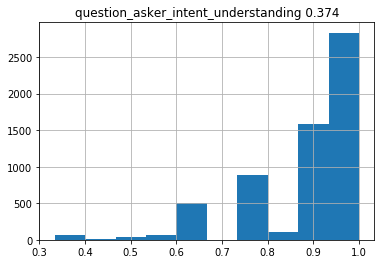

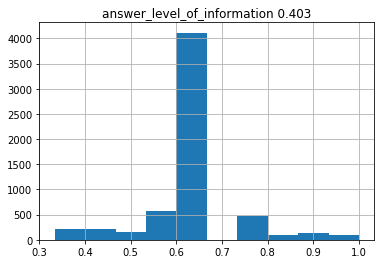

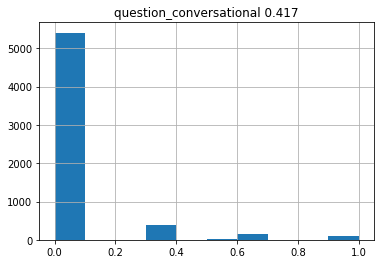

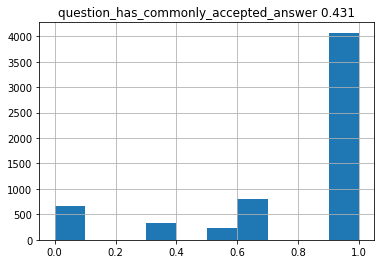

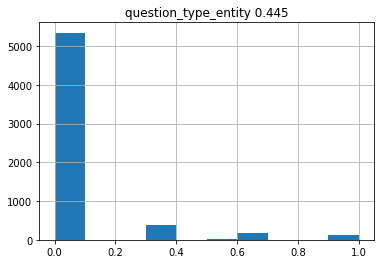

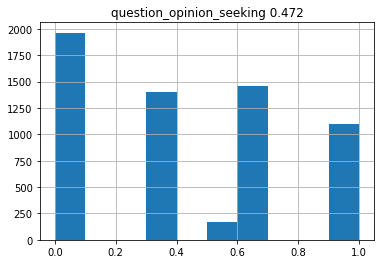

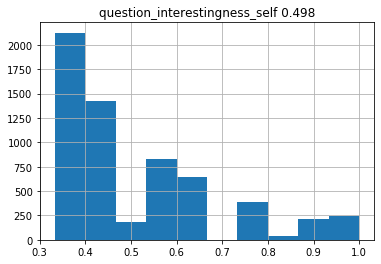

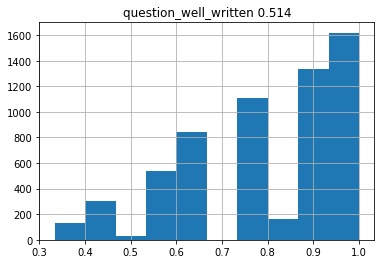

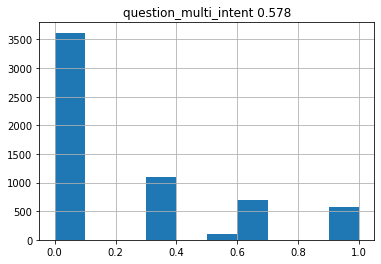

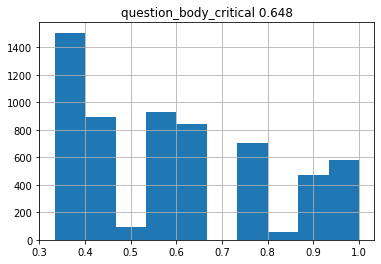

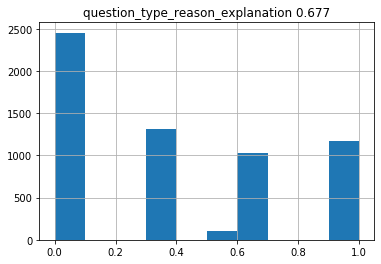

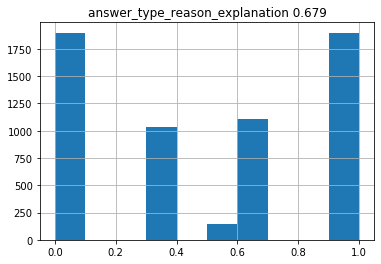

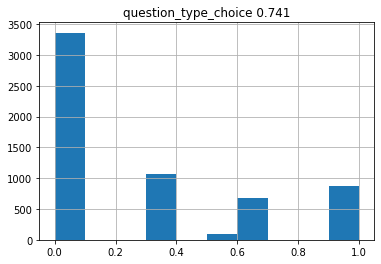

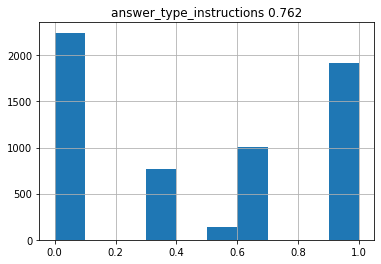

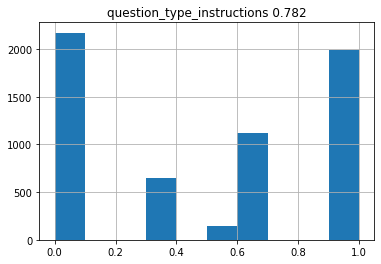

In [28]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')